In [5]:
import numpy as np 
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import scipy as sp

from sklearn.cross_decomposition import PLSRegression

def get_data(hemisphere):
    X = pd.read_csv('https://raw.githubusercontent.com/JonahKember/hippocampus_clustering/main/' + hemisphere + '_nmf_input_raw.csv')
    X = X.to_numpy()
    return(X)

def get_age(hemisphere):
    Y = pd.read_csv(hemisphere + '_age.csv')
    age = Y['Age'].to_numpy()
    return(age)



Define function for calculating B-spline coefficients.

In [6]:
from scipy.interpolate import UnivariateSpline

def get_spline_coeffs(X,age,voxel):

    metrics = np.linspace(0,X.shape[1],4, dtype=int)
    spline_coeffs = []

    for n in range(3):
        y = X[voxel,metrics[n]:metrics[n+1]]
        idx = np.argsort(age)
        spline = UnivariateSpline(age[idx],y[idx])
        spline_coeffs = np.append(spline_coeffs,spline.get_coeffs())
        
    return(spline_coeffs)



Calculate the B-spline coefficients at each voxel.

In [7]:
hemisphere = 'right'
X = get_data(hemisphere)
age = get_age(hemisphere)


n_voxels = X.shape[0]
n_coeffs = 12


data = np.zeros([n_voxels,n_coeffs])

for voxel in range(n_voxels):
    data[voxel,:] = get_spline_coeffs(X,age,voxel)



Run K-means to cluster the coefficients into sets of voxels.

/home/jkember/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/jkember/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/jkember/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/jkember/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/jkembe

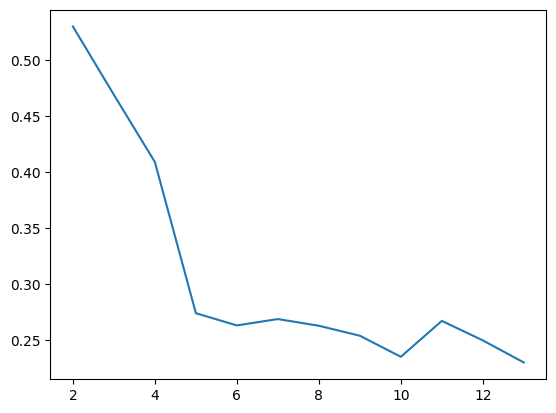

In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

n_k = 14

silhouette = np.zeros(n_k)

for k in range(2,n_k):
    model = KMeans(n_clusters=k)
    model.fit_transform(data)

    clusters = model.labels_
    silhouette[k] = silhouette_score(data,clusters)

plt.plot(np.arange(2,n_k),silhouette[2::])


/home/jkember/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


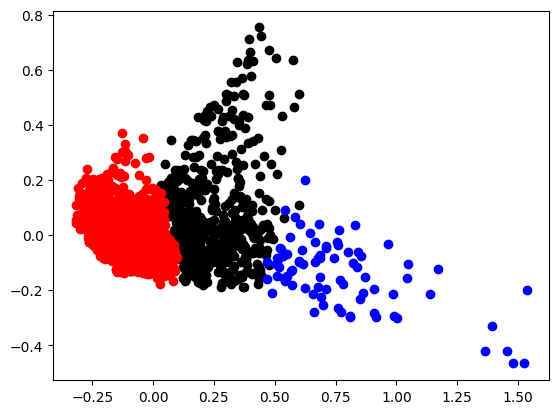

In [17]:
from sklearn.decomposition import PCA

k = 3

# Cluster
model = KMeans(n_clusters=k)
model.fit_transform(data)
clusters = model.labels_

# Run PCA
model = PCA()
data_pca = model.fit_transform(data)

colors = ['black','red','blue','orange','green']
for n in range(k):
    plt.scatter(data_pca[clusters == n,0],data_pca[clusters == n,1],c=colors[n])


In [18]:
from sklearn.metrics import adjusted_rand_score

y = pd.read_csv('right_subfield_labels.csv')
y = y.to_numpy()
y = y.reshape(y.shape[0],)

adjusted_rand_score(y,clusters)



0.045572188684053494

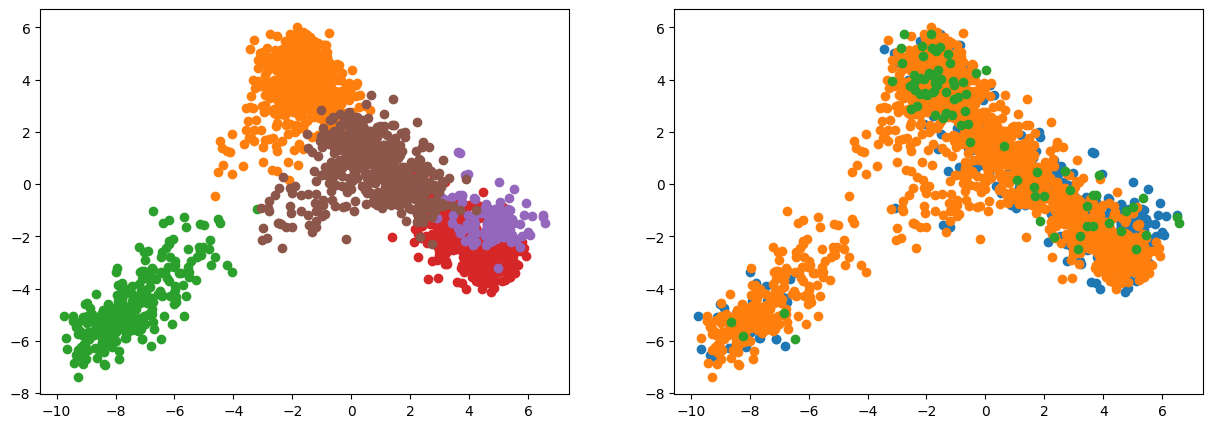

In [20]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Load subfield labels.
y = pd.read_csv('right_subfield_labels.csv')
y = y.to_numpy()
y = y.reshape(y.shape[0],)

model = LinearDiscriminantAnalysis(n_components = 2)
model.fit_transform(X,y)
lda_components = model.transform(X)

# Plot Subfields against NMF components in LDA space. 
fig, ax = plt.subplots(1,2,figsize = [15,5])

for k in range(np.max(y) + 1):
    ax[0].plot(lda_components[y == k,0], lda_components[y == k,1], marker='o', linestyle='')    
    ax[1].plot(lda_components[clusters == k,0], lda_components[clusters == k,1], marker='o', linestyle='') 

plt.show()
